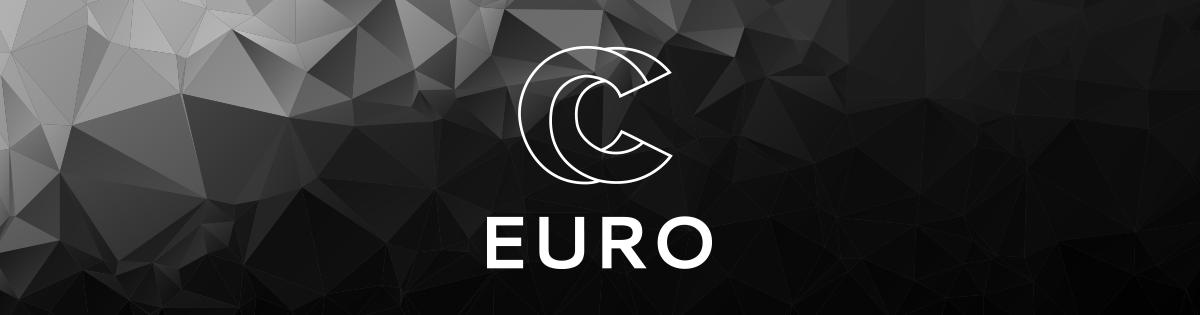

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from pandas.core.common import random_state

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import model_selection

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor



# Loading the Data:
 In order to load a dataset we will use the [seaborn online repository](https://github.com/mwaskom/seaborn-data). This enables quick and easy access to several well-documented datasets, ready for analysis.

Seaborn is a data visualization library, similar to matplolib. Although it is based on the latter, seaborn offers a wider range of themes and visuals, in order to add aesthetics to the plots.

In [3]:
# get names of available model names
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'taxis',
 'tips',
 'titanic']

For the purpose of this tutorial, we will use the classic diamonds datasets, with over 50000 entries. Specifically, the dataset includes the following features: 

* **price**: Diamond price in US dollars 

* **carat**: weight of the diamond in grams

* **cut**: quality of the cut (Fair, Good, Very Good, Premium, Ideal)

* **color**:  diamond colour, from J (worst) to D (best)

* **clarity**:  a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

* **x**: length in mm 

* **y**: width in mm 

* **z**: depth in mm 

* **depth**: total depth percentage - given by $\frac{2z}{(x + y)}$

* **table**: width of top of diamond relative to widest point

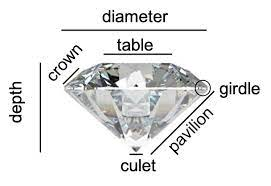

In [4]:
#https://bookdown.org/yih_huynh/Guide-to-R-Book/diamonds.html
df = sns.load_dataset('diamonds')
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


As one would guess, the natural thing to do with this dataset is to use the above features in order to predict the price of a given diamond. 

In the field of data science, the task of predicting a continous quantity (in our case the price), is called *regression*. 

On the other hand, if we wanted to predict a class label (good vs bad, healthy vs unhealthy), we would be dealing with a *classification task*.


 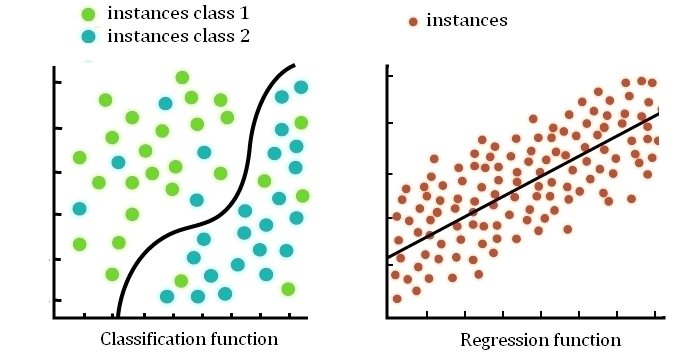


Source:  [Belkacem, Sami. (2021). Machine learning approaches to rank news feed updates on social media.](https://www.researchgate.net/publication/350993856_Machine_learning_approaches_to_rank_news_feed_updates_on_social_media/)

Both of these problems fall under the scope of *Supervised Learning*, where we use labelled datasets in order to train predictive models. 

The underlying theory is outside of the scope of this notebook, but for those intereseted, there ae tons of resources online!



# Exploratory Analysis & Feature Engineering

We can add some additional features to our data by applying domain knowledge and some common sense:

In [5]:

df['volume'] = df['x']*df['y']*df['z']
# df['PricePerMiligram'] = df['price']/(df['carat']*200)
# df['PricePerCarat'] = df['price']/df['carat']

We first print some summary statistics in order to gain a better understanding abou the numerical features of the dataset.

In [7]:
# print summary statistics
df.describe()

,carat,depth,table,price,x,y,z,volume
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734,129.849403
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699,78.245262
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000,65.136830
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000,114.808572
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000,170.842451
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000,3840.598060


Just by examining the above statistics, we notice something wrong with the volume feature. Namely, we notice a very large maximum value of 3840 $mm^3$. This is an extreme observation as the mean volume is only 129 $mm^3$. We will later plot the observations in order to gain a better understanding of this issue.

In [8]:
# define target variable
target_variable = 'price'

# get numerical and categorical columns
numCols = df.select_dtypes("number").columns
catCols = df.select_dtypes("category").columns
numCols= list(set(numCols))
catCols= list(set(catCols))

In [9]:
catCols

['color', 'clarity', 'cut']

In [10]:
# print unique values in categorical columns:
for colname in catCols:
  print('Unique {} values:'.format(colname), df[colname].unique().tolist())
  print()

Unique color values: ['E', 'I', 'J', 'H', 'F', 'G', 'D']

Unique clarity values: ['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']

Unique cut values: ['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']



Before diving deeper into the analysis, it is a good idea to check whether we have any missing values, as these may affect results further down the line. We can do this using the ```DataFrame.isnull()``` method:

In [11]:
print('Missing Values in each Column:')
df.isnull().sum()

Missing Values in each Column:


carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
volume     0
dtype: int64

Fortunately, we do not have any missing values, so we can proceed normally.

In the case of missing values we could either just drop the corresponding records, or find a suitable way to fill in the gaps.

Another sensible thing to do is to check the correlation between our features and the target variable in order to better understand the importance of each column. We can calculate the* Pearson Correlation* using the ```DataFrame.corr()``` method.

Note that the Pearson Correlation only describes the **linear** relationship between two distributions, therefore it is not an absolute measure of feature importance. 

In complex, real world datasets we often need to capture non-linear relationships between our features!

In [12]:
# get correlation between each feature and the target variable
df.corr()[target_variable]

carat     0.921591
depth    -0.010647
table     0.127134
price     1.000000
x         0.884435
y         0.865421
z         0.861249
volume    0.902385
Name: price, dtype: float64

As expected, the features that describe the size and weight of the diamond, have a strong linear relationship with the target variable. 

Besides the target variable, we can also plot a correlation matrix for the entire dataset. Note that this will have duplicate values (corr(x,y) = corr(y,x)). As we don't want these dublicates to show up, we mask the upper triangular part of the matrix.

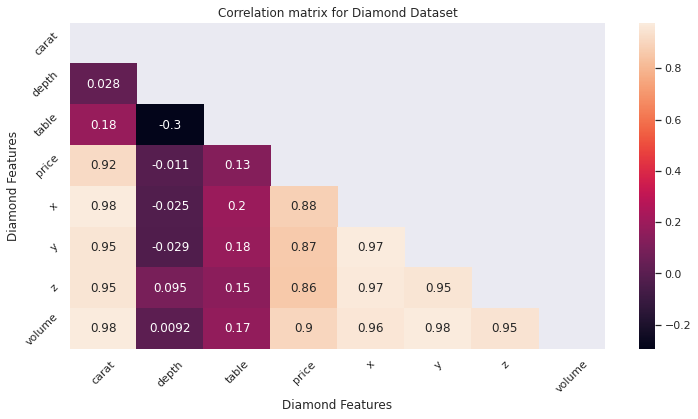

In [13]:
# Visualise correlation matrix

corr_mat = df.corr()
mask = np.triu(np.ones_like(corr_mat, dtype=bool))


plt.figure(figsize = (12,6))
heatmap = sns.heatmap(corr_mat, mask = mask, annot = True)
heatmap.set(xlabel='Diamond Features', ylabel='Diamond Features',
       title = "Correlation matrix for Diamond Dataset")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

Most of the relationships above are quite intuitive, but it is good to confirm this mathematically. 

Besides correlations, we can also plot the frequency distribution of each variable. We can do this individually or for the entire dataset, as seen in the cells below:

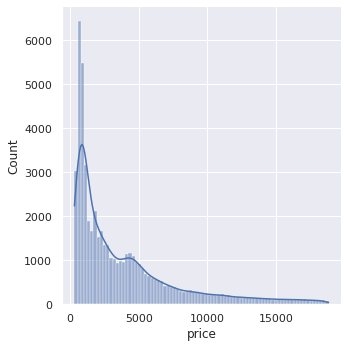

In [14]:
# plot target variable distribution
sns.displot(df[target_variable], kde = True) #KDE) is a non-parametric way to estimate the probability density function of a random variable

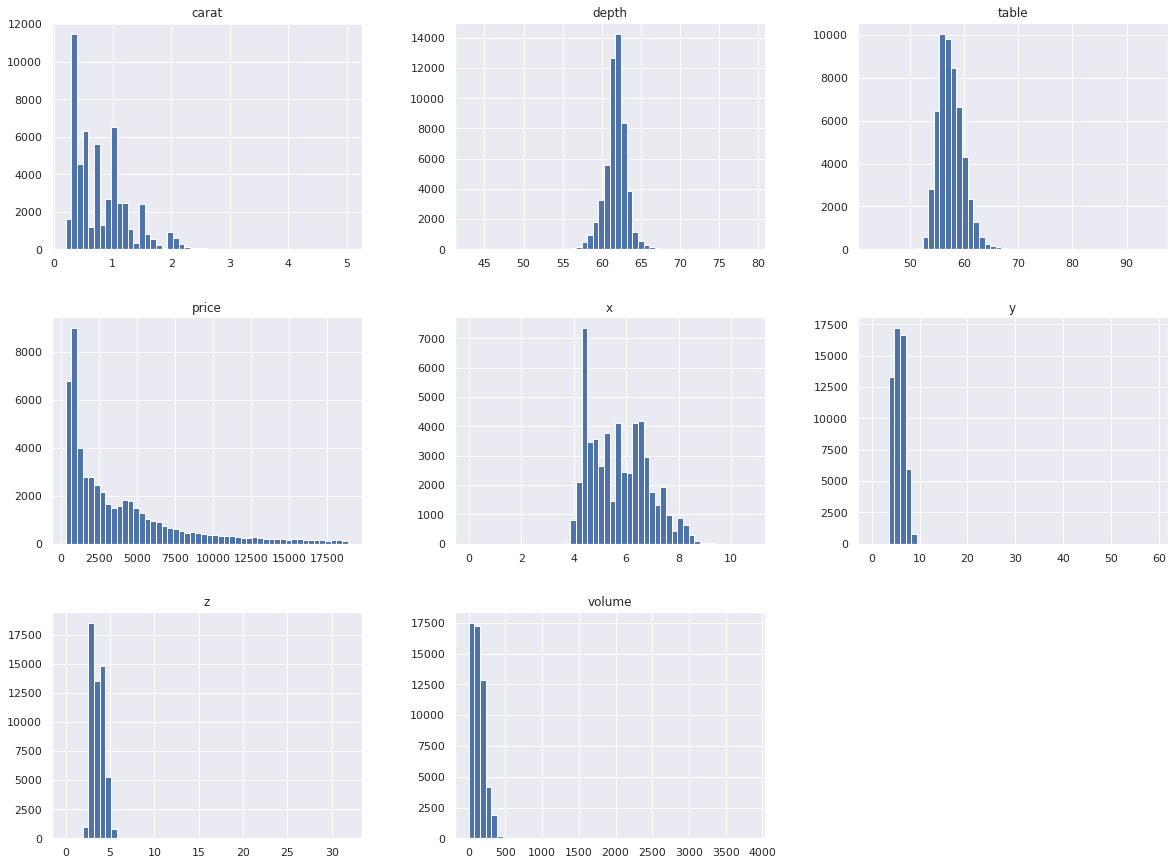

In [15]:
# get distributions for all variables
df.hist(bins = 50, figsize = (20, 15))
plt.show()

Our analysis of course would not be complete without visualising relationships between variables. We can do this using scatterplots, and either seaborn or matplotlib.

Text(0, 0.5, 'price')

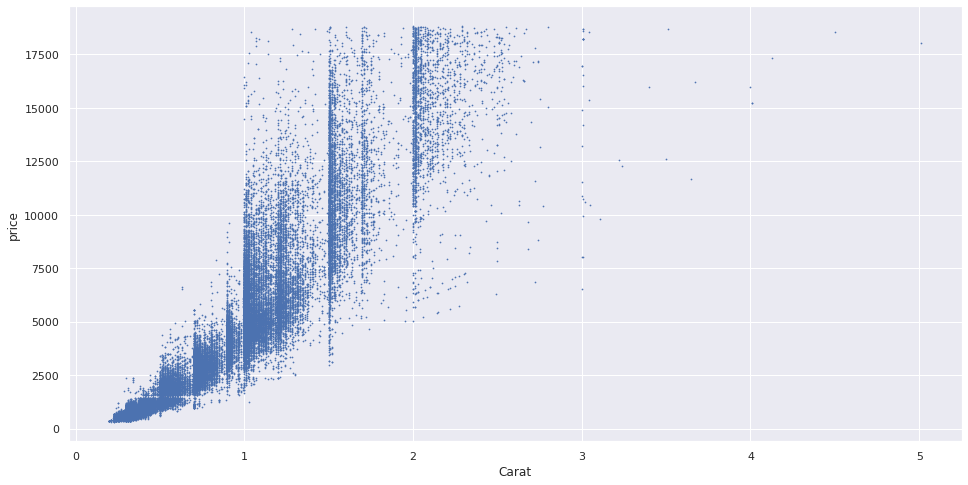

In [16]:
plt.figure(figsize = (16,8))
plt.scatter(df['carat'], df[target_variable], s = 0.5)
plt.xlabel('Carat')
plt.ylabel(target_variable)

Just by looking at the plot above we can easily see the strong linear relationship between the carats (weight) of a diamond and its price. 

If we examine this plot a bit better, we discover two other interesting facts:



*   The price seems to be capped somewhere near 175000
*   Carat measurments are not continous (some values might've been rounded). This can be seen from the vertical lines at rounded carat values (0.5, 1, 1.5, 2)

There is not much to do here but it is important to understand any possible issues in the dataset, as these may affect our prediction results.



Text(0, 0.5, 'price')

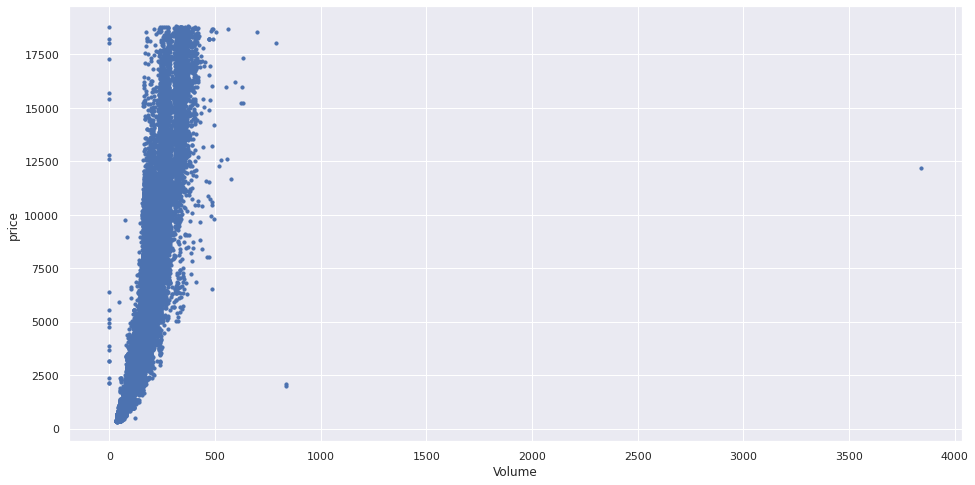

In [17]:
plt.figure(figsize = (16,8))
plt.scatter(df.volume, df[target_variable], s = 10)
plt.xlabel('Volume')
plt.ylabel(target_variable)

The above plot confirms that there are indeed some extreme values in the 'Volume' column. Further, these extreme values correspond to a relatively low price. 

This specifically happens for diamonds with volume greater than 750 $mm^3$, and for only four instances. Thus it is safe to discard the corresponding entries and plot the updated scatterplot.

Text(0, 0.5, 'price')

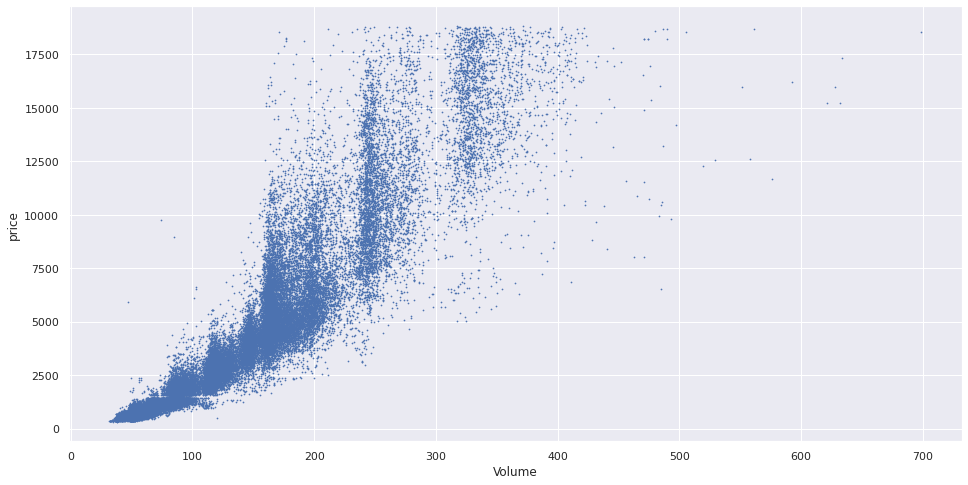

In [18]:
df = df[df.volume < 750]
df = df[df.volume > 0]
plt.figure(figsize = (16,8))
plt.scatter(df.volume, df[target_variable], s = 0.5)
plt.xlabel('Volume')
plt.ylabel(target_variable)

Voila! The updated plot looks much better :)
We can easily plot the scatterplots for every pair in our dataset using the ```pd.plotting.scatter_matrix()``` method. Note that this can take some time, especially for high-dimensional datasets as we visualise $N^2$ scatterplots.

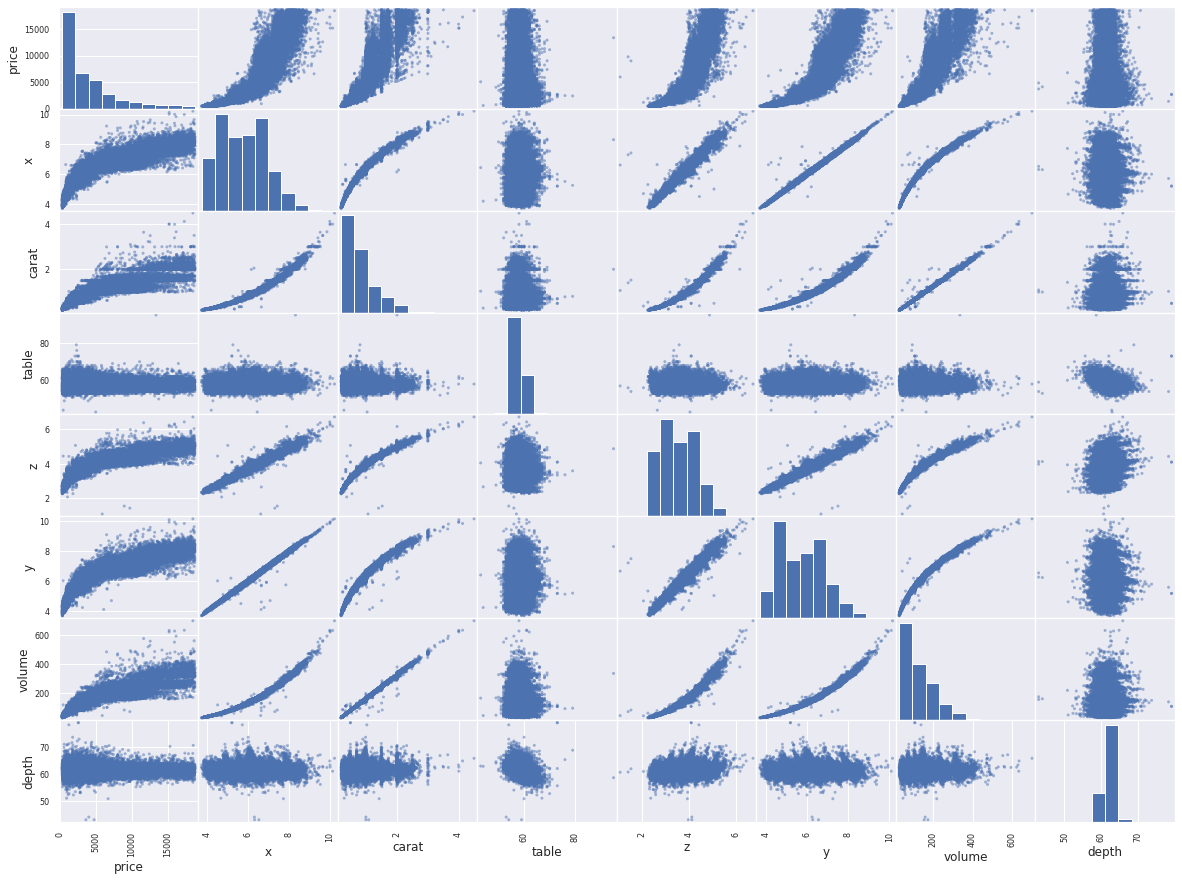

In [19]:
pd.plotting.scatter_matrix(df[numCols], figsize=(20, 15))
plt.show()

Let's also examine the relationship between the price and our categorical variables. As a reminder, we have the following categorical columns in our dataset:

* **cut**: quality of the cut (Fair, Good, Very Good, Premium, Ideal)

* **color**:  diamond colour, from J (worst) to D (best)

* **clarity**:  a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))


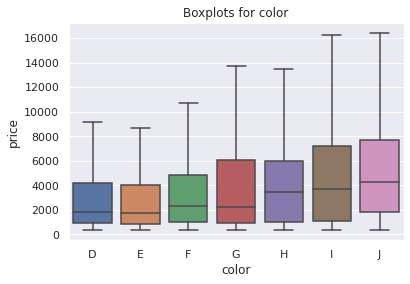

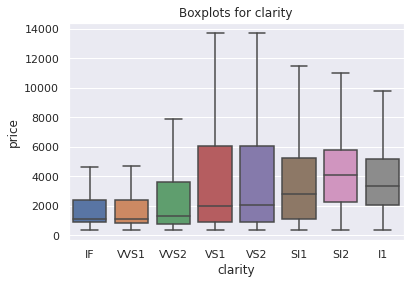

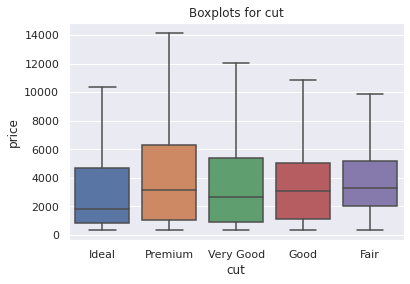

In [20]:
for colname in catCols:
  plt.figure()
  plt.title('Boxplots for {}'.format(colname))
  sns.boxplot(x=colname,
              y=target_variable,
              data=df,
              showfliers = False)
  plt.show()
  

The above is a bit counter-intuitve. Specifically, as color, cut and clarity get worse, the price increases!!!

Is there something wrong here? 

Actually, before jumping into conclusions, let's plot the relationships between the categorical variables, the carat and the volume of a diamond (You can see where I'm going with this)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
color:
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



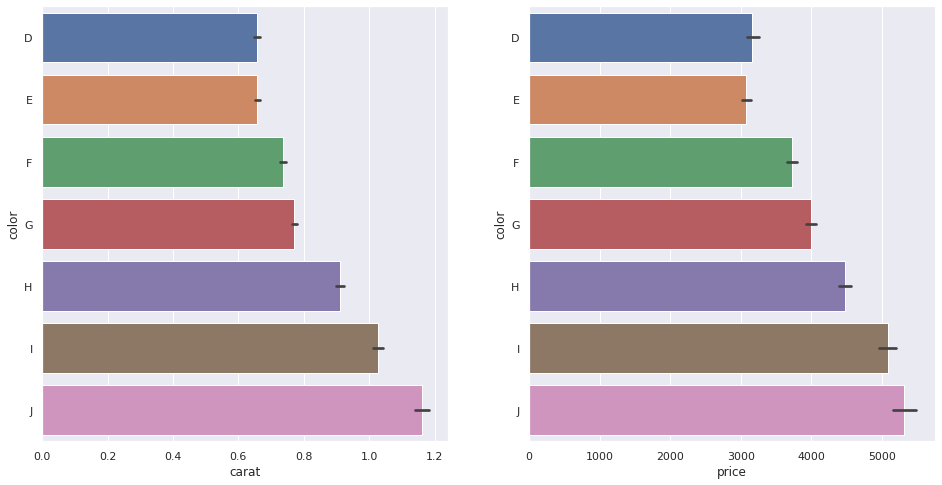

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
clarity:
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



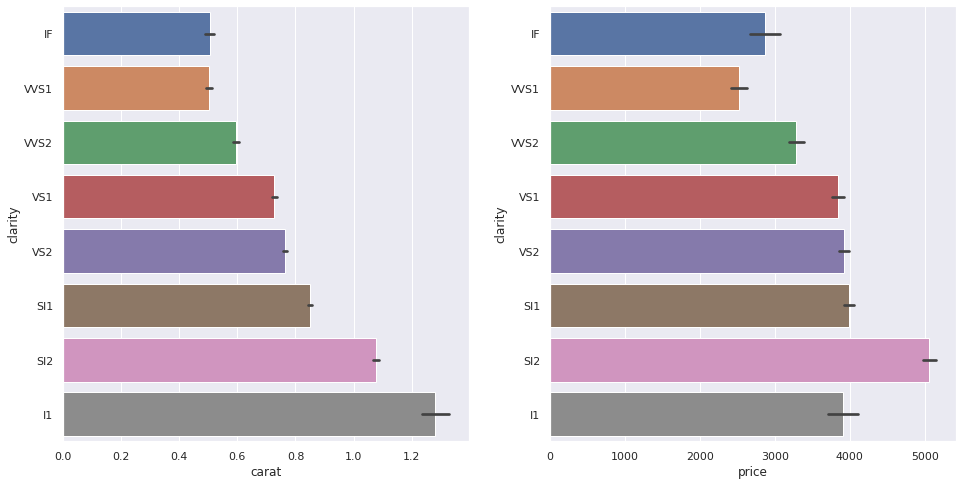

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
cut:
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



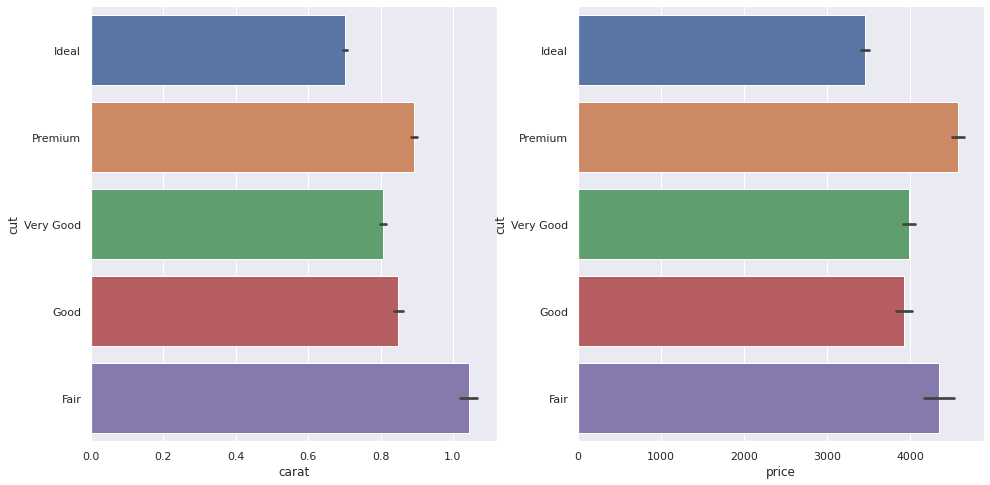

In [21]:
num_plots = 2
if target_variable != 'price':
  num_plots = 3
for colname in catCols:
  print(200*'-')
  print(colname+':')
  print(200*'-')
  fig, ax =plt.subplots(1, num_plots, figsize = (16,8))
  sns.barplot(x = "carat", y = colname, data = df, ax = ax[0])
  sns.barplot(x = target_variable, y = colname, data = df, ax = ax[1])
  if target_variable != 'price':
    sns.barplot(x = 'price', y = colname, data = df, ax = ax[2])
  print()
  plt.show()

Indeed, as weight and volume increase, the color, clarity and cut quality all go down. Thus, price is also affected! 

Now that we've analysed our data and have a good understanding of the relationships between our features, let's move on to the interesting part: Creating our predictive models!

# Preparing data for training:

First thing first, we need to split our dataset to train and test sets. We will use the train set to fit our models and then evaluate the performance of the estimators on the test set. This step is extremely important as we do not want to expose our model to data that will be used for evaluation.

For those not familiar with the concept, a nice introduction can be found [here](https://towardsdatascience.com/understanding-train-test-split-scikit-learn-python-ea676d5e3d1).

In [22]:
# define features dataframe.

# essentially we want this: 
# feature_df = df.loc[:, df.columns != target_variable]
feature_df = df[df.columns[~df.columns.isin(['price',
                                             'PricePerCarat',
                                             'PricePerMiligram'])]]
# define the target dataframe:
target_df = df[[target_variable]]

# split dataset (90% train - 10% test, and shuffle)
# the random state arguement ensures that results are reproducible
X_train, X_test, y_train, y_test = train_test_split(feature_df,
                                                    target_df,
                                                    test_size = 0.1,
                                                    shuffle = True,
                                                    random_state = 42)

In [23]:
# print features
X_train

,carat,cut,color,clarity,depth,table,x,y,z,volume
14286,1.06,Very Good,H,VS2,62.5,57.0,6.47,6.49,4.05,170.060715
6806,1.00,Premium,E,SI2,62.6,60.0,6.35,6.33,3.97,159.576135
12065,1.04,Premium,H,SI1,61.6,58.0,6.53,6.48,4.01,169.680744
46922,0.52,Ideal,G,VS1,61.8,55.0,5.21,5.17,3.21,86.463597
38571,0.40,Premium,H,VS1,62.6,58.0,4.73,4.66,2.94,64.802892
...,...,...,...,...,...,...,...,...,...,...
11290,1.29,Very Good,F,SI2,63.4,57.0,6.92,6.77,4.35,203.790540
44751,0.51,Premium,F,VS2,61.4,58.0,5.13,5.09,3.14,81.990738
38177,0.40,Ideal,F,VVS2,61.5,59.0,4.75,4.81,2.94,67.171650
860,0.90,Premium,J,SI1,62.8,59.0,6.13,6.03,3.82,141.202098


Now that we have our features ready we are ready to train right?

Well, not yet. One last thing we need to do is to encode our data. That is, map the categorical variables to a numerical representation (Computers only know how to read numbers). 

In order to do this we employ a method called [One Hot Encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). In other words, for each unique value in a categorical column, we create a binary feature. This will slightly increase the number of features but it is a necessary step.

At this point one might ask, why not map each unique value to a separate number in the same column. Well this is possible, it will add a sense of ordering to the aformenioned column (value mapped to 3 will be more important than value mapped to 1).

This might be the case here (clarity, color and cut) but does not always hold.

In [25]:

onehotencoder = OneHotEncoder(handle_unknown='ignore')

# fit encoder to training data
# we always want to act as if the test data does not exist
# Potential unseen values will be mapped to an unkown categroy
onehotencoder = onehotencoder.fit(X_train[catCols])

# transform data
X_train_transformed = onehotencoder.transform(X_train[catCols])

# get encoded column names and create encoded dataframe
enc_df = pd.DataFrame(X_train_transformed.toarray())
enc_df.columns = onehotencoder.get_feature_names_out()
X_train_encoded = pd.concat(
    [enc_df, X_train.drop(catCols,axis=1).reset_index(drop=True)], axis=1
    )


# use fitted encoder to transofrm the test set
X_test_transformed = onehotencoder.transform(X_test[catCols])
enc_df = pd.DataFrame(X_test_transformed.toarray())
enc_df.columns = onehotencoder.get_feature_names_out()
X_test_encoded = pd.concat(
    [enc_df, X_test.drop(catCols,axis=1).reset_index(drop=True)], axis=1
    )


In [26]:
X_train_encoded.head()

,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,...,cut_Ideal,cut_Premium,cut_Very Good,carat,depth,table,x,y,z,volume
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.06,62.5,57.0,6.47,6.49,4.05,170.060715
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.00,62.6,60.0,6.35,6.33,3.97,159.576135
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.04,61.6,58.0,6.53,6.48,4.01,169.680744
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.52,61.8,55.0,5.21,5.17,3.21,86.463597
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.40,62.6,58.0,4.73,4.66,2.94,64.802892



As mentioned above, machines only read numbers. Without additional context, a feature with larger values (and thus greater range) will be interpreted as more important. In addition, larger distances within features might cause slower convergence in distance based and gradient based algorithms. To solve problems of this nature, we want to bring features into a specific scale.

In data science, this method is referred to as *scaling*. There are two main approaches to help us scale the variables in a dataset, namely:

* Standard Scaling (Standardization), where $X_{scaled} = \frac{X - \mu}{\sigma}$. Standardization centers the feature around a mean of 0 and std of 1. That is, we bring the feature to a standard normal distribution. It is more likely to be usueful when the features are normally distributed

* Min Max Scaling (Normalization), where $X_{scaled} = \frac{X - X_{min}}{X_{max} - X_{min}}$. Here the features are brought to a range [0,1] and the shape of the original distrubution is maintained. This method is a safer choice when we don't know anything about the distribution of the feature

Both methods are sensitive to outliers (outliers affect the empirical mean and standard deviation). Of course, other scaling methods exist, but they will not be covered here.

In [27]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
y_train = y_train[target_variable].ravel()
y_test = y_test[target_variable].ravel()

# Model Training & Evaluation

In order to properly evaluate our model(s) we need to define the suitable evaluation metrics. These are numerical metrics that measure the performance of a predictor on a specific task.

Since we are performing a regression task, we need to measure how "far" from the true value ($Y_i$) is our prediction ($\hat{Y_i}$). Specifically, we can use the below scores in order to measure the errors of our predictor:



*   Mean Squared Error (MSE): $MSE = \frac{1}{n}\sum_{i-1}^n(Y_i - \hat{Y_i})^2$
*  Root Mean Squared Error (RMSE): $RMSE = \sqrt(MSE) = \sqrt(\frac{\sum_{i-1}^n(Y_i - \hat{Y_i})^2}{n})$
* Mean Absolute Error (MAE): $MAE = \frac{1}{n}\sum_{i-1}^n|Y_i - \hat{Y_i}|$
* Coefficient of Determination (R squared): $R^2 = 1 - \frac{SS_{res}}{SS_{total}}$ where $SS_{res} = \sum_{i-1}^n(Y_i - \hat{Y_i})^2$ and $SS_{total} = \sum_{i-1}^n(Y_i - \overline{Y_i})^2$

Besides these performance metrics, it is good practice to perform some kind of error analysis. Although there are many ways to do this, we will be focusing on *residual plots*. That is, for each prediction, we will plot the individual error in order to identify possible patters. Ideally, we want errors to be randomly distributed.


In [28]:
def show_performance(y_test, y_pred):
  
  print(100*'-')
  print('Performance Metrics:')
  print(100*'-')
  residuals = y_test-y_pred
  print('MSE:',mse(y_test, y_pred))
  print('RMSE:',mse(y_test, y_pred)**0.5)
  print('MAE:',mae(y_test, y_pred))
  print('R2 Score:', r2_score(y_test, y_pred))
  print(100*'-')
  print()

  # actual vs predicted
  plt.figure(figsize = (12,6))
  plt.title('Predicted vs Actual')
  plt.scatter(y_test, y_pred, s=1)
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.show()
  print(100*'-')
  print()
  
  #Residual Plot
  plt.figure(figsize = (12,6))
  plt.title('Residual Plot')
  plt.scatter(y_test, residuals, s=1)
  plt.xlabel('Actual')
  plt.ylabel('Residuals')
  plt.show()



## Individual Models:

The theoretical explanation of each algorithm that is used here is beyond the scope of the presentation, but you are encouraged to do some background reading on them. 

Although we might actually get good scores without undersanding the underlying mathematics behind the algorithm, gaining a good understanding of the tools used is a vital step for tackling more complex problems.

Anyhow, we will compare some very well established regression algorithms, namely:



*   Linear Regression (LR) - Gradient Descent
*   K-Nearest Neighbor Regression (KNN) - Distance Based
*   Extreme Gradient Boosting (XGB) - Tree Based (No need for scaling)
*   Random Forest Regression (RF) - Tree Based (No need for scaling)




----------------------------------------------------------------------------------------------------
Performance Metrics:
----------------------------------------------------------------------------------------------------
MSE: 1170477.0230694779
RMSE: 1081.8858641601146
MAE: 708.9295020400593
R2 Score: 0.9270416895522853
----------------------------------------------------------------------------------------------------



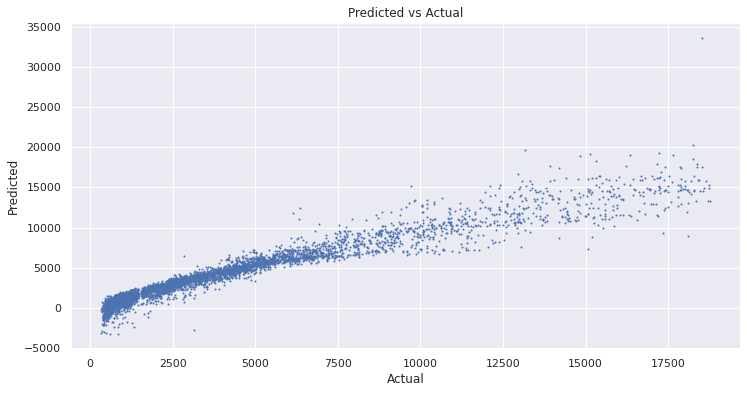

----------------------------------------------------------------------------------------------------



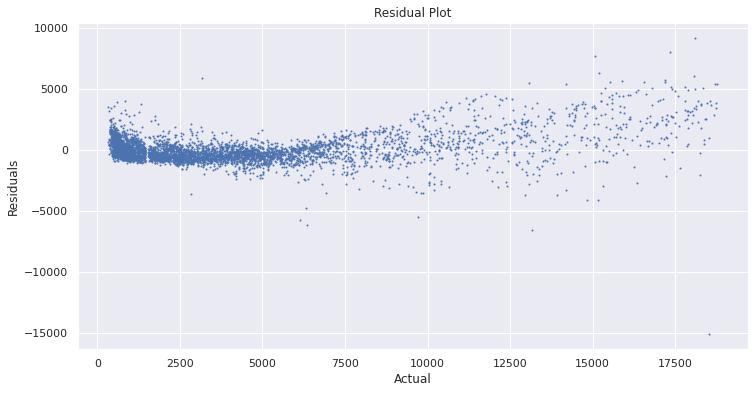

In [29]:
reglr = LinearRegression()
reglr.fit(X_train_scaled, y_train)
y_pred = reglr.predict(X_test_scaled)
show_performance(y_test, y_pred)

----------------------------------------------------------------------------------------------------
Performance Metrics:
----------------------------------------------------------------------------------------------------
MSE: 467234.61452522257
RMSE: 683.5456199298059
MAE: 329.3473293768546
R2 Score: 0.9708762774607442
----------------------------------------------------------------------------------------------------



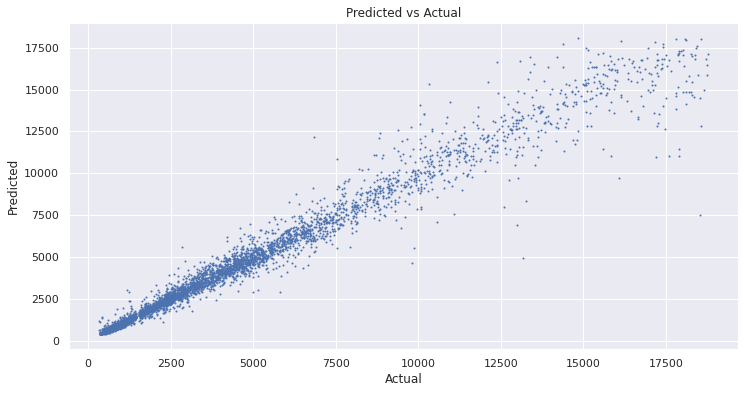

----------------------------------------------------------------------------------------------------



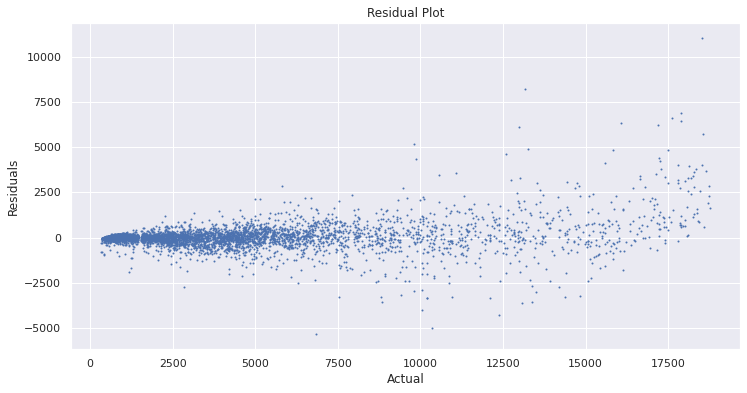

In [30]:
knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
show_performance(y_test, y_pred)

----------------------------------------------------------------------------------------------------
Performance Metrics:
----------------------------------------------------------------------------------------------------
MSE: 508126.7418360003
RMSE: 712.8300932452279
MAE: 397.2589928929415
R2 Score: 0.968327384607313
----------------------------------------------------------------------------------------------------



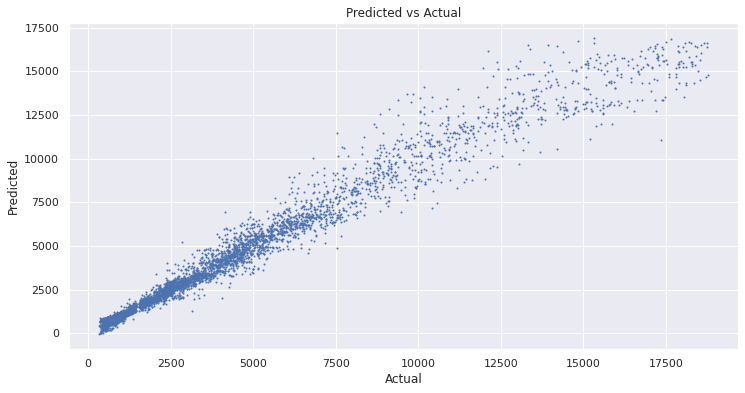

----------------------------------------------------------------------------------------------------



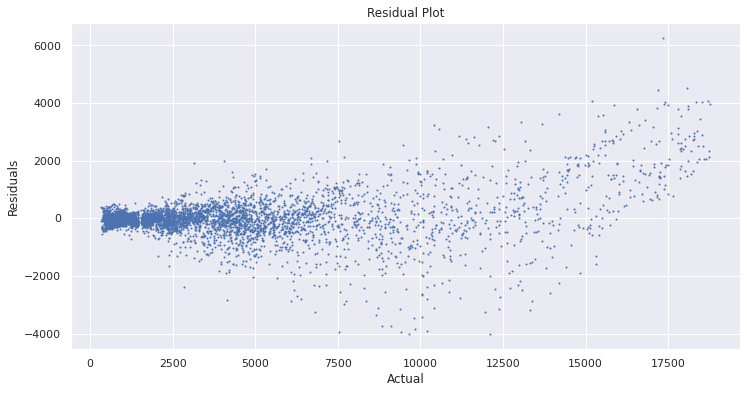

In [31]:
xgb_reg = XGBRegressor(objective='reg:squarederror')
xgb_reg.fit(X_train_scaled, y_train)
y_pred = xgb_reg.predict(X_test_scaled)
show_performance(y_test, y_pred)

----------------------------------------------------------------------------------------------------
Performance Metrics:
----------------------------------------------------------------------------------------------------
MSE: 260194.73999132248
RMSE: 510.09287388800334
MAE: 256.397361143493
R2 Score: 0.9837815110907798
----------------------------------------------------------------------------------------------------



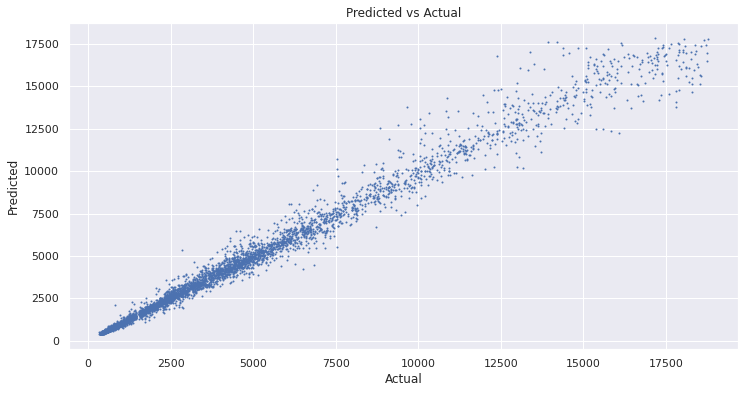

----------------------------------------------------------------------------------------------------



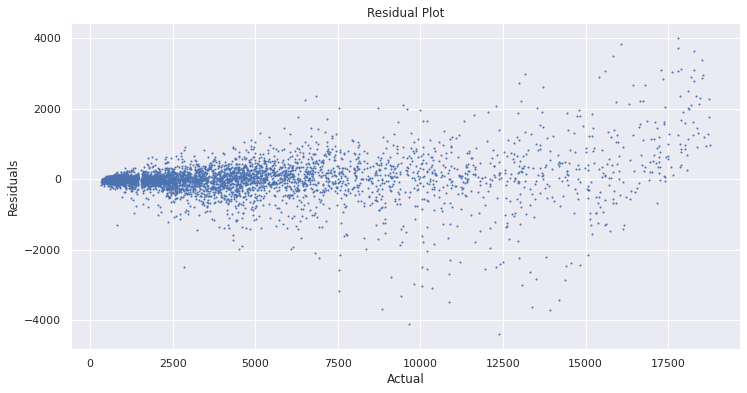

In [32]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_scaled, y_train)
y_pred = forest_reg.predict(X_test_scaled)
show_performance(y_test, y_pred)

## Cross Validation for Model Selection

In order to properly evaluate the performance of a model, individual metrics are not sufficient. We also want to check the ability of the model to generalize. That is, we wouldn't want performance to change for different samples from the same distribution.

Imagine having a relatively small dataset, and performing a 80-20 train/test split. It is possible that we've biased our model towards the training set as we've missed out some observations that have only occured in the test set.

In order to prevent the above from happening, data scientists use a method called Cross-Validation (In our case K-Fold Cross-Validation).

By splitting the data into k-folds, and re-training the model for each combination, we give the model the chance to see every bit of the dataset during training. Therefore, the average performance across splits will give us a clear picture of our  model's ability to generalise.


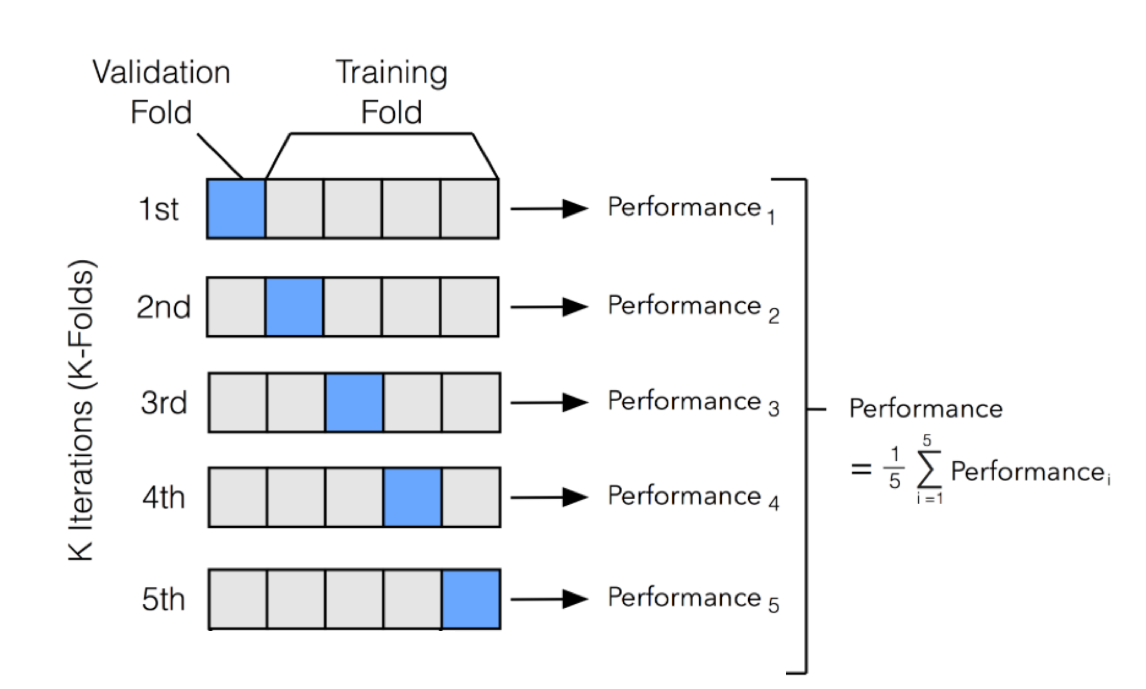

[Link to KFolds Figure Source](https://rpubs.com/jvaldeleon/forest_repeat_cv)

In [33]:

model_dict = {'LR':LinearRegression(),
              'XGB': XGBRegressor(objective='reg:squarederror'),
              'KNN': KNeighborsRegressor(),
              'RF': RandomForestRegressor()}

model_names = []
model_results = []
# 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'
eval_score = 'r2'
scoring = {'RMSE': 'neg_root_mean_squared_error',
           'MAE': 'neg_mean_absolute_error',
           'R2': 'r2'}

for name, model in model_dict.items():
  folds = model_selection.KFold(n_splits = 5,
                                shuffle = True,
                                random_state = 42)
  cross_val_score = model_selection.cross_validate(model,
                                                    X_train_scaled,
                                                    y_train,
                                                    cv = folds,
                                                    scoring = scoring)
  model_names.append(name)
  model_results.append(cross_val_score)
  print(100*'-')
  print('CV Results for {}:'.format(name))
  print(100*'-')
  print()
  print(100*'-')
  for key in cross_val_score.keys():
    print('Mean {}: {}'.format(key,
                               np.abs(
                                   np.round(cross_val_score[key].mean(),4)
                                   )
                               )
    )
  print(100*'-')
  print('\n\n')
  # print('Mean {} for {}: {}'.format(eval_score,
  #                                   name,
  #                                   cross_val_score.mean()))
  # print('{} Standard devation for {}: {}'.format(eval_score,
  #                                                name,
  #                                                cross_val_score.std()))
  # print()



----------------------------------------------------------------------------------------------------
CV Results for LR:
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Mean fit_time: 0.0774
Mean score_time: 0.0048
Mean test_RMSE: 1112.8099
Mean test_MAE: 721.6263
Mean test_R2: 0.922
----------------------------------------------------------------------------------------------------



----------------------------------------------------------------------------------------------------
CV Results for XGB:
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Mean fit_time: 2.9997
Mean score_time: 0.0247
Mean test_RMSE: 736.8449
Mean test_MAE: 405.7186
Mean test_R2: 0.9658
-----------------

In [34]:
performance_metric = 'test_RMSE'

# add mean performances (chosen metric) to dictionary
# where the key is the model name

performance_dict = {
    model_names[i]:np.abs(
        model_results[i][performance_metric].mean()
        ) for i in range(len(model_names))
    }

# find corresponding model in model dict
name_best = min(performance_dict, key=performance_dict.get)
model_best = model_dict[name_best]
print('Model with best {}: {}'.format(performance_metric, model_best))


Model with best test_RMSE: RandomForestRegressor()


In [ ]:

def plot_size_vs_acc(df_in, percentage_list, model = RandomForestRegressor()):
  sizes, rmses, maes, r2s = [], [], [], []
  for i in percentage_list:
    size = int(np.floor(len(df_in)*i))
    sizes.append(size)
    df = df_in.sample(size)
    feature_df = df.loc[:, df.columns != target_variable]
    target_df = df[[target_variable]]
    X_train, X_test, y_train, y_test = train_test_split(feature_df,
                                                        target_df,
                                                        test_size = 0.1,
                                                        shuffle = True,
                                                        random_state = 42)
    
    onehotencoder = OneHotEncoder(handle_unknown='ignore')

    onehotencoder = onehotencoder.fit(X_train[catCols])
    X_train_transformed = onehotencoder.transform(X_train[catCols])

    enc_df = pd.DataFrame(X_train_transformed.toarray())
    enc_df.columns = onehotencoder.get_feature_names_out()
    X_train_encoded = pd.concat(
        [enc_df, X_train.drop(catCols,axis=1).reset_index(drop = True)],
         axis=1
         )



    X_test_transformed = onehotencoder.transform(X_test[catCols])
    enc_df = pd.DataFrame(X_test_transformed.toarray())
    enc_df.columns = onehotencoder.get_feature_names_out()
    X_test_encoded = pd.concat(
        [enc_df, X_test.drop(catCols,axis=1).reset_index(drop = True)],
         axis=1
         )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_encoded)
    X_test_scaled = scaler.transform(X_test_encoded)
    y_train = y_train[target_variable].ravel()
    y_test = y_test[target_variable].ravel()

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = mse(y_test, y_pred)**0.5
    rmses.append(rmse)
    maes.append(mae(y_test, y_pred))
    r2s.append(r2_score(y_test, y_pred))
  return sizes,rmses,maes,r2s
        


In [ ]:
# percentage_list = [i/20 for i in range(1,21)]
# sizes,rmses,maes,r2s = plot_size_vs_acc(df, percentage_list)

# plt.figure(figsize = (12,6))
# plt.title('Sample size vs error')
# plt.plot(sizes,maes)
# plt.xlabel('Number of samples used')
# plt.ylabel('MAE')
# plt.show()


In order to see how sample size affects performance, we run the entire experiment with several different sample sizes, for the best performing model. As this is time consuming to run (cell commented out above), the relevant plot is attached below.

As expected, an increase in sample size, leads to an increase in performance. However, it is worth noting that afrer 25000 samples, the graph reaches a plateu. In other words, we can achieve the same performance that we see for 50000 instances, with almost half the size. 



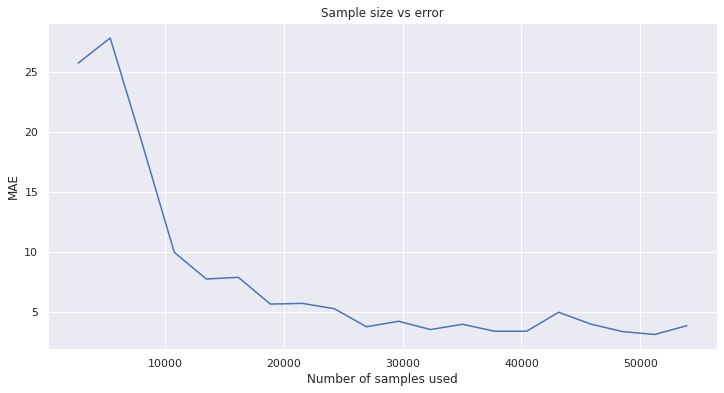

In [ ]:
# model = XGBRegressor()
# parameters = {
#               'objective':['reg:squarederror'],
#               'learning_rate': [.03, 0.05, .07], #so called `eta` value
#               'max_depth': [7],
#               'min_child_weight': [4],
#               'silent': [1],
#               'subsample': [0.8],
#               'colsample_bytree': [0.8],
#               'n_estimators': [500, 100]}

# xgb_grid = GridSearchCV(model,
#                         parameters,
#                         n_jobs = 5,
#                         verbose=True)

# xgb_grid.fit(X_train_scaled,
#          y_train)